In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import chardet

Задание: Разработать SVM-классификатор (метод опорных векторов) для набора данных. В качестве языка программирования использовать Pyhton. Необходимо обучить, проверить качество классификатора на обучающей и тестовой выборках: рассчитать общую точность, Recall, Precision, F1-measure. Оценить число опорных векторов. Рассмотреть различные типы ядра (линейное, RBF, полиномиальное, сигмоидное (тангенсальное)), различные сочетания значений параметра регуляризации С и параметров ядра. Перебор по сетке (grid search)

In [26]:
file_path = "Ирисы.txt"
with open(file_path, "rb") as f:
    raw_data = f.read()
    detected_encoding = chardet.detect(raw_data)["encoding"] # вычисляем кодировку 
data = pd.read_csv(file_path, sep="\t", encoding=detected_encoding)
data.head()


,Длина чашелистика,Ширина чашелистика,Длина лепестка,Ширина лепестка,Класс
0,"5,1","3,5","1,4","0,2",Iris-setosa
1,"4,9",3,"1,4","0,2",Iris-setosa
2,"4,7","3,2","1,3","0,2",Iris-setosa
3,"4,6","3,1","1,5","0,2",Iris-setosa
4,5,"3,6","1,4","0,2",Iris-setosa


In [27]:
data.shape

(150, 5)

In [28]:
data.isna().sum()

Длина чашелистика     0
Ширина чашелистика    0
Длина лепестка        0
Ширина лепестка       0
Класс                 0
dtype: int64

In [29]:
data.dtypes

Длина чашелистика     object
Ширина чашелистика    object
Длина лепестка        object
Ширина лепестка       object
Класс                 object
dtype: object

Все признаки указываются как объекты. Заменим запятые на точки, чтобы привести их к типу float

In [30]:
for column in data.columns[:-1]:
    data[column] = data[column].str.replace(',', '.').astype(float)
print(data['Длина чашелистика'].unique())
print(data['Ширина чашелистика'].unique())
print(data['Длина лепестка'].unique())
print(data['Ширина лепестка'].unique())
print(data['Класс'].unique())

[5.1 4.9 4.7 4.6 5.  5.4 4.4 4.8 4.3 5.8 5.7 5.2 5.5 4.5 5.3 7.  6.4 6.9
 6.5 6.3 6.6 5.9 6.  6.1 5.6 6.7 6.2 6.8 7.1 7.6 7.3 7.2 7.7 7.4 7.9]
[3.5 3.  3.2 3.1 3.6 3.9 3.4 2.9 3.7 4.  4.4 3.8 3.3 4.1 4.2 2.3 2.8 2.4
 2.7 2.  2.2 2.5 2.6]
[1.4 1.3 1.5 1.7 1.6 1.1 1.2 1.  1.9 4.7 4.5 4.9 4.  4.6 3.3 3.9 3.5 4.2
 3.6 4.4 4.1 4.8 4.3 5.  3.8 3.7 5.1 3.  6.  5.9 5.6 5.8 6.6 6.3 6.1 5.3
 5.5 6.7 6.9 5.7 6.4 5.4 5.2]
[0.2 0.4 0.3 0.1 0.5 0.6 1.4 1.5 1.3 1.6 1.  1.1 1.8 1.2 1.7 2.5 1.9 2.1
 2.2 2.  2.4 2.3]
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [31]:
data.dtypes

Длина чашелистика     float64
Ширина чашелистика    float64
Длина лепестка        float64
Ширина лепестка       float64
Класс                  object
dtype: object

In [32]:
X = data.iloc[:, :-1]
y = data["Класс"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Метод опорных векторов (англ. SVM, support vector machine) строит гиперплоскость в n-мерном пространстве для разделения объектов двух или более классов. Гиперплоскость выбирается таким образом, чтобы максимизировать расстояние между ней и ближайшими объектами разных классов (зазор). Объекты, которые расположены ближе всего к гиперплоскости, называются опорными векторами

Различные сочетания значений параметра регуляризации C: параметр C в методе опорных векторов управляет степенью штрафа, который накладывается на ошибочные классификации в обучающей выборке. Проще говоря, C определяет, насколько строго модель будет стремиться к тому, чтобы все данные в обучающей выборке были классифицированы правильно. Большое значение C: модель старается классифицировать каждый образец правильно, даже если для этого необходимо иметь более сложную границу решения. Это может привести к переобучению. Малое значение C: модель менее строго относится к ошибкам, допуская некоторые ошибки на обучающей выборке в пользу более простой и обобщающей модели. Это может помочь избежать переобучения, но может привести к недообучению

Будем рассматривать следующие ядра (по заданию):
1) 'linear': линейное ядро. Это самое простое ядро, которое пытается провести прямую (или гиперплоскость) между классами. Используется, когда данные линейно разделимы, то есть классы можно отделить прямой линией
2) 'rbf': радиально-базисное (RBF) ядро. Это нелинейное ядро, которое особенно полезно, когда границы между классами сложные. RBF создает овальные зоны, которые охватывают классы. Полиномиальное ядро позволяет проводить криволинейные границы между классами.
3) 'poly': полиномиальное ядро. Оно работает лучше, когда линейное ядро недостаточно гибко, но RBF слишком избыточно
4) 'sigmoid': сигмоидное ядро (также можно назвать тангенсальным). Оно создает функции разделения, похожие на сигмоидальные функции в нейронных сетях. Используется реже, но может быть полезным в некоторых ситуациях, где нужна "S"-образная разделительная линия

А также следующие параметры ядра:
1) gamma - это параметр для управления степенью влияния отдельных точек данных в RBF и полиномиальных ядрах. Значение 'scale' или 'auto' управляет тем, как gamma рассчитывается автоматически в зависимости от данных
2) degree - параметр, который используется только для полиномиального ядра и определяет степень полинома

In [ ]:
svc = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100], # C
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # типы ядер
    'gamma': ['scale', 'auto'], 
    'degree': [2, 3, 4]
}

Используем GridSearchCV для поиска лучших параметров модели KNN с использованием кросс-валидации (cv=5). Перебор по сетке (Grid Search) — это метод подбора оптимальных гиперпараметров для модели путём перебора всех возможных комбинаций значений гиперпараметров из заданного набора. Алгоритм работы:
1) Для каждого гиперпараметра фиксируется несколько значений
2) Перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется
3) Выбирается комбинация, на которой модель показывает лучшее качество


cv (cross-validation) определяет количество фолдов (частей), на которые будет разделён обучающий набор данных для проведения кросс-валидации. Процесс обучения и оценки: Модель обучается 5 раз (столько же, сколько фолдов). Каждый раз модель тренируется на 4 из 5 фолдов и оценивается на оставшемся фолде. Это позволяет модели протестироваться на каждом фолде по одному разу, что уменьшает вероятность переоценки её качества. Итоговая метрика усредняется по всем 5 фолдам

In [35]:
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

Проанализируем вывод: 

GridSearchCV выполнил поиск по сетке параметров для классификатора SVC
1) cv=5: кросс-валидация на 5 фолдах
2) estimator=SVC(): базовый классификатор, которым является SVC
3) param_grid: словарь параметров, по которым выполняется поиск
4) scoring='accuracy': в качестве метрики для выбора наилучшей модели используется точность

best_estimator_: здесь представлен лучший классификатор, найденный в процессе подбора параметров. Лучшая модель имеет следующие параметры:
1) C=0.1: Значение регуляризационного параметра
2) degree=2: Степень полинома для полиномиального ядра
3) gamma='auto': Параметр gamma, который был автоматически определён
4) kernel='poly': Было выбрано полиномиальное ядро

Для подтверждения полученного результата информация о лучшем классификаторе была выведена повторно

In [36]:
best_model = grid_search.best_estimator_ # извлекаем лучшую модель, найденную в ходе поиска по сетке параметров

Оценка на обучающей выборке

In [37]:
y_train_pred = best_model.predict(X_train)

In [38]:
new_df = pd.DataFrame({'Actual': y_train, "Predicted": y_train_pred}) 
print(new_df.head())

             Actual        Predicted
22      Iris-setosa      Iris-setosa
15      Iris-setosa      Iris-setosa
65  Iris-versicolor  Iris-versicolor
11      Iris-setosa      Iris-setosa
42      Iris-setosa      Iris-setosa


Вычислим метрики Accuracy, Recall, Precision и F1 Score для оценки классификатора

1) Accuracy — это доля объектов, для которых правильно предсказали класс
2) Recall (полнота) показывает, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм. Полнота отвечает на вопрос: "Сколько из всех истинных положительных примеров удалось правильно предсказать?". Высокое значение recall говорит о том, что модель успешно находит большинство положительных примеров
3) precision (точность) — это доля истинно положительных ответов среди всех положительных ответов модели. Точность показывает, какая доля объектов, предсказанных моделью как принадлежащие к определенному классу, действительно относится к этому классу. Высокая точность означает, что большая часть примеров, предсказанных как положительные, действительно являются положительными
4) F1 Score -  это гармоническое среднее между precision и recall. Она дает единый показатель качества классификации, учитывая как полноту, так и точность. Формула: 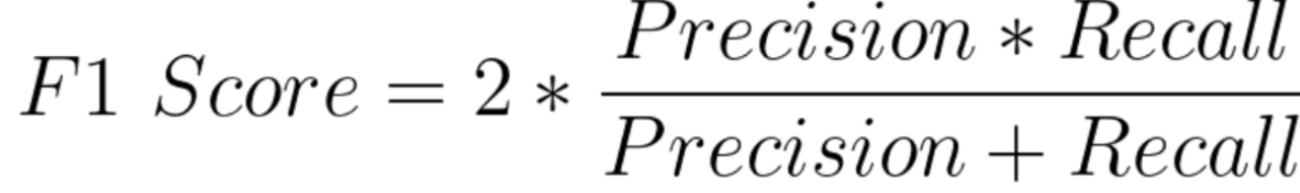

В нашей задаче положительные и отрицательные примеры зависят от рассматриваемого класса: например, если в определённый момент рассматриваем Iris-setosa как положительный класс, то все образцы Iris-setosa будут положительными примерами, а все остальные будут отрицательными. Для каждой метрики (precision, recall и др.) используются понятия "положительные" и "отрицательные" примеры, чтобы вычислить, насколько хорошо модель умеет классифицировать положительные объекты (то есть, принадлежащие к целевому классу)

In [39]:
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Recall: {recall_score(y_train, y_train_pred, average='weighted'):.2f}")
print(f"Precision: {precision_score(y_train, y_train_pred, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.2f}")

Accuracy: 0.98
Recall: 0.98
Precision: 0.98
F1 Score: 0.98


Все метрики имеют значение 0,98. Это говорит о том, что модель хорошо обучена на предоставленных данных

Оценка на тестовой выборке

In [40]:
y_pred = best_model.predict(X_test)

In [41]:
new_df = pd.DataFrame({'Actual': y_test, "Predicted": y_pred}) 
print(new_df.head())

              Actual        Predicted
73   Iris-versicolor  Iris-versicolor
18       Iris-setosa      Iris-setosa
118   Iris-virginica   Iris-virginica
78   Iris-versicolor  Iris-versicolor
76   Iris-versicolor  Iris-versicolor


In [42]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")

Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1 Score: 1.00


Все метрики имеют значение 1, что говорит о том, что в данном случае модель работает идеально. Однако нельзя сказать точно, что модель идеальна, стоит рассмотреть большее количество данных

Опорные вектора — это те примеры обучающего набора данных, которые "поддерживают" оптимальную разделяющую гиперплоскость между классами в модели SVM. Эти данные ключевые, так как они определяют, где проходит граница разделения классов

In [43]:
print("Число опорных векторов для каждого класса:")
print(best_model.n_support_)

Число опорных векторов для каждого класса:
[ 4 12 11]


Для первого класса было использовано 4 опорных вектора. Для второго класса — 12 опорных векторов. Для третьего класса — 11 опорных векторов. Количество опорных векторов показывает, насколько сложна граница между классами: чем больше опорных векторов, тем сложнее разделить данные. Попробуем визуализировать с использованием метода главных компонент (PCA) для понижения размерности данных и отображения их на двумерном графике. Будем использовать PCA, так как у нас 4 признака, а для удобного отображения на графике лучше использовать 2

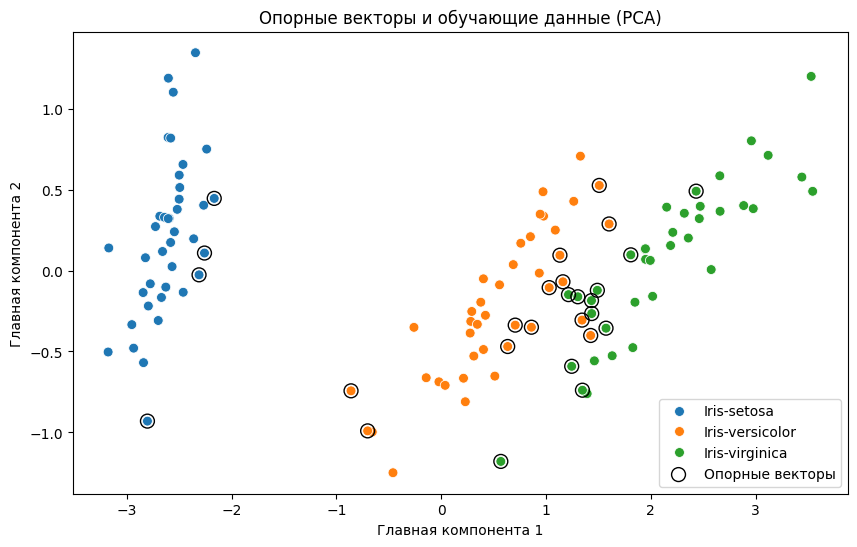

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, s=50, markers="o")
support_vectors_pca = pca.transform(best_model.support_vectors_)
plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100, facecolors='none', edgecolors='k', label='Опорные векторы')
plt.title("Опорные векторы и обучающие данные (PCA)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend()
plt.show()

Черные обводки показывают, какие точки являются опорными векторами. Чем сложнее граница между классами, тем больше опорных векторов потребуется для корректного построения этой границы. Опорные векторы располагаются вблизи границы раздела между классами. На рисунке видно, что, например, опорные вектора для iris-setosa четко обозначают границу этого класса